In [1]:
import nnapprox as nna
%load_ext autoreload
%autoreload 2

In [2]:
# torch is already imported in nnfunction?
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
# prepare data in dataframe
import pandas as pd
import numpy as np
# make grid
x1, x2 = np.meshgrid(np.linspace(0,10,101), np.linspace(0,10,101))
x1 = x1.flatten()
x2 = x2.flatten()
def y(x1, x2):
    return 2*x1 + 3*x2**2 + 1
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y(x1, x2)})
print(data)

         x1    x2      y
0       0.0   0.0    1.0
1       0.1   0.0    1.2
2       0.2   0.0    1.4
3       0.3   0.0    1.6
4       0.4   0.0    1.8
...     ...   ...    ...
10196   9.6  10.0  320.2
10197   9.7  10.0  320.4
10198   9.8  10.0  320.6
10199   9.9  10.0  320.8
10200  10.0  10.0  321.0

[10201 rows x 3 columns]


In [5]:
func = nna.func(
    verbose=True, input=['x1', 'x2'],
    output=['y'],  
    model = nna.DenseNN(
                input_size=2,
                hidden_sizes=[60, 60],
                output_size=1,
            )
)
# specify a map from input to NN (inverse not needed)
func.set_map_to_NN('x2', lambda x: np.sqrt(x))
Xs, Ys = func.prepare_data(data)
loss = func.train(Xs, Ys, epochs=10000, device=device, lr=0.005)

DenseNN(
  (act): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=2, out_features=60, bias=True)
    (1): Linear(in_features=60, out_features=60, bias=True)
  )
  (output): Linear(in_features=60, out_features=1, bias=True)
)
Next steps:
>> func.set_map() # optimize parameter distribution over activation function domain (input) and range (output) 
>> func.train() # train neural network model
>> func.save(filename) # save function approximation to file
Device for training: mps
Training data with input shape torch.Size([10201, 2]) and output shape torch.Size([10201, 1]).


Training: 100%|██████████| 10000/10000 [00:30<00:00, 325.79it/s]

Training complete; left training mode for faster evaluation! To re-enter training mode call `func.model.train(True)`.


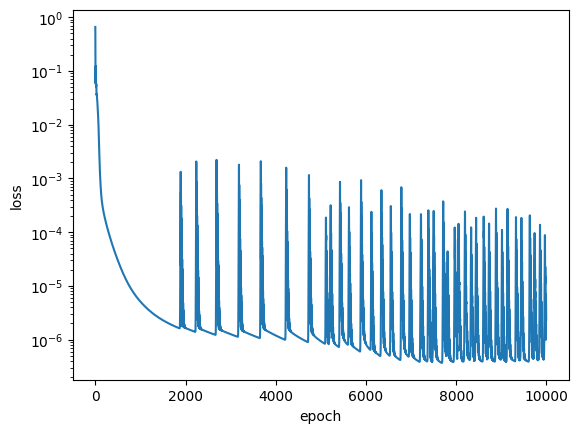

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()

/var/folders/1n/3p6th0xd5058w0ldlcm64jcm0000gn/T/ipykernel_25937/2848586214.py:13: RuntimeWarning: overflow encountered in power
  func.set_map_from_NN('y', lambda Y: 10**Y)
/var/folders/1n/3p6th0xd5058w0ldlcm64jcm0000gn/T/ipykernel_25937/2848586214.py:13: RuntimeWarning: overflow encountered in power
  func.set_map_from_NN('y', lambda Y: 10**Y)


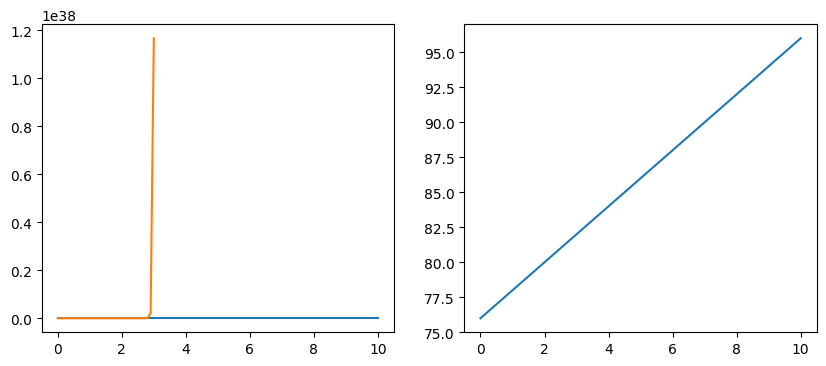

In [7]:
# compare the result
fig,axs = plt.subplots(1,2, figsize=(10,4))
# slice at x1=5
data0 = data[data['x1']==5]
axs[0].plot(data0['x2'], data0['y'], label='data')
# plot function approximation
x1 = np.ones(101)*5
x2 = np.linspace(0,10,101)
axs[0].plot(x2, func(x1,x2)[0], label='approximation')
# slice at x2=5
data0 = data[data['x2']==5]
axs[1].plot(data0['x1'], data0['y'], label='data')
# plot function approximation
x2 = np.ones(101)*5
x1 = np.linspace(0,10,101)
axs[1].plot(x1, func(x1,x2)[0], label='approximation')


/var/folders/1n/3p6th0xd5058w0ldlcm64jcm0000gn/T/ipykernel_25937/2848586214.py:13: RuntimeWarning: overflow encountered in power
  func.set_map_from_NN('y', lambda Y: 10**Y)
/var/folders/1n/3p6th0xd5058w0ldlcm64jcm0000gn/T/ipykernel_25937/2848586214.py:13: RuntimeWarning: overflow encountered in power
  func.set_map_from_NN('y', lambda Y: 10**Y)


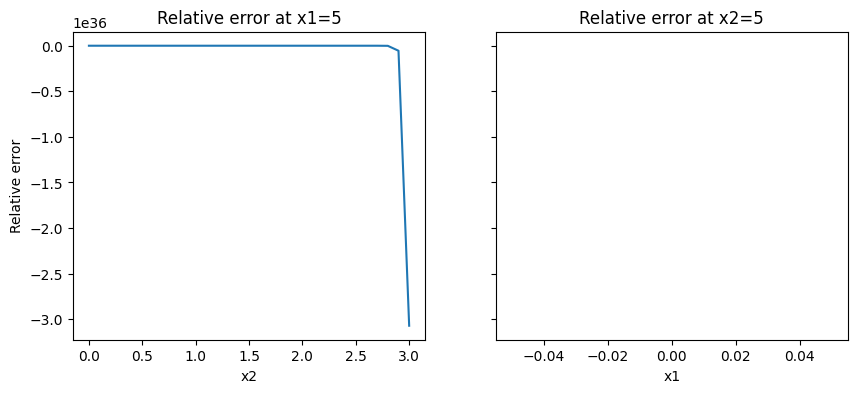

In [8]:
# plot relative error
fig,axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
# slice at x1=5
data0 = data[data['x1']==5]
axs[0].plot(data0['x2'], (data0['y']-func(np.ones(len(data0))*5, data0['x2'])[0])/data0['y'], label='data')
# slice at x2=5
data0 = data[data['x2']==5]
axs[1].plot(data0['x1'], (data0['y']-func(data0['x1'], np.ones(len(data0))*5)[0])/data0['y'], label='data')

axs[0].set_title('Relative error at x1=5')
axs[1].set_title('Relative error at x2=5')
axs[0].set_xlabel('x2')
axs[1].set_xlabel('x1')
axs[0].set_ylabel('Relative error')
plt.show()

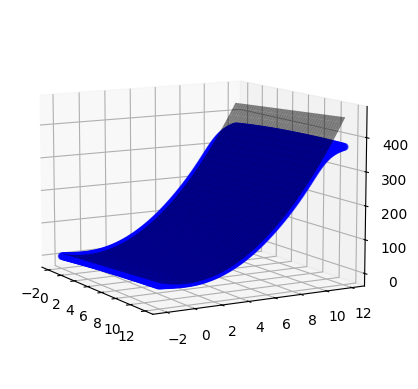

In [38]:
# more general visualization
x1,x2 = np.meshgrid(np.linspace(-2,12,141), np.linspace(-2,12,141))
# plot 2D function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, y(x1,x2).reshape(141,141), color='k', alpha=0.5)

x1 = x1.flatten()
x2 = x2.flatten()  
# plot 2D function approximation
ax.scatter(x1, x2, func(x1,x2)[0], color='b', alpha=0.5)

# change perspective
ax.view_init(10, -30)



In [39]:
x1,x2 = np.meshgrid(np.linspace(-2,12,141), np.linspace(-2,12,141))
func(x1,x2)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.